In [8]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
import numpy as np
from scipy.sparse import csr_array, lil_array
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint

from SVD import Metrics, SVDPredictor, LogisticSVD, FastLogisticSVD
from RecData import RecData

In [2]:
recs = pd.read_csv('data/recommendations.csv')
# recs = pd.read_csv('data/pruned.csv')

# Remove old ratings
recs = recs.sort_values(by=['date'], ascending=False)
recs.drop_duplicates(subset= ['app_id', 'user_id'], inplace=True) 

USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

print("Shape:", recs.shape)
recs.head()

Shape: (1482532, 3)


,app_id,is_recommended,user_id
279261,271590,True,2706940
968812,698540,True,3892918
965466,1085510,True,4590796
965540,1949960,False,3058171
1373726,1088850,True,2018014


In [3]:
random.seed(42)
np.random.seed(42)

rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

del recs

start_time = time.time()
print("Creating splits...")
train_data, test = rec_data.train_test_split(test_size=0.2)
print("First split done.")
train_data, val = train_data.train_test_split(test_size=0.2)
print("Done creating splits in", time.time() - start_time, "seconds")

Creating utility matrix...
Done utility matrix.
Creating splits...
First split done.
Done creating splits in 4.649838209152222 seconds


In [4]:
rec_data._num_users

63175

In [5]:
# random.seed(42)
# np.random.seed(42)

# rec_data = RecData()
# rec_data.create_from_dataframe(recs)
# rec_data.set_titles(titles)

# del recs

# print("Creating splits...")
# train_data, val, test = rec_data.leave_k_out_split(k=1)
# print("Done creating splits.")

In [6]:
del item_data
del titles

In [ ]:
EPOCHS = 30

random.seed(42)
np.random.seed(42)

# Fit and predict with svd
svd_predictor = FastLogisticSVD(
    train_data.get_num_users(), train_data.get_num_items(), 2, k=20, 
    learning_rate=0.1, C=0.02)
svd_predictor.fit(train_data.get_matrix(), EPOCHS, validation_set=val, early_stop=False)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

Epoch 0/Training error: 0.6921672309201284/	Validation error: 0.6923102426040525/Time: 5.87 seconds
Epoch 1/Training error: 0.4598560610046211/	Validation error: 0.4828452165798823/Time: 3.61 seconds
Epoch 2/Training error: 0.3865513665728606/	Validation error: 0.41591767711048294/Time: 3.43 seconds
Epoch 3/Training error: 0.37002277161721536/	Validation error: 0.40241943064326735/Time: 3.56 seconds
Epoch 4/Training error: 0.3615596452176083/	Validation error: 0.3972743308606597/Time: 3.46 seconds
Epoch 5/Training error: 0.3519719172166776/	Validation error: 0.39279995274006024/Time: 3.41 seconds
Epoch 6/Training error: 0.33777883769812717/	Validation error: 0.38798366650548344/Time: 3.43 seconds
Epoch 7/Training error: 0.3210946961553309/	Validation error: 0.3846156499772993/Time: 3.45 seconds
Epoch 8/Training error: 0.30137833295721583/	Validation error: 0.3835159023313021/Time: 3.66 seconds
Epoch 9/Training error: 0.279482341249425/	Validation error: 0.38334059307977586/Time: 3.66 s

In [8]:
# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([svd_predictor, rec_data, train_data, val, test], file)
print("Done saving model.")

Saving model...
Done saving model.


In [10]:
svd_predictor.continue_fit(5, early_stop=False)

Epoch 0
Training error: 0.693128905622481
Validation error: 0.6931453979236265
Time: 4.2 seconds
Epoch 1
Training error: 0.6931215425681037
Validation error: 0.6931426737233639
Time: 3.77 seconds
Epoch 2
Training error: 0.6931090862088692
Validation error: 0.6931356447591928
Time: 3.85 seconds
Epoch 3
Training error: 0.6930834610492901
Validation error: 0.6931173446550369
Time: 3.7 seconds
Epoch 4
Training error: 0.6930235853044583
Validation error: 0.6930693499219578
Time: 3.46 seconds


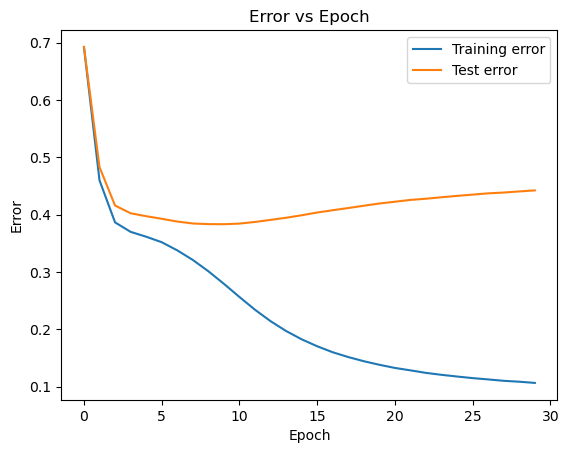

In [15]:
# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

In [19]:
j = 2
# Test top-n list for user j
top_n = svd_predictor.top_n(j, 20)
print("Predicted top n:")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

# User j true top n list
print("True top n:")
true_top = rec_data.top_n(j, 5000)
pprint([rec_data.index_to_title(index) for _, index in true_top])

Predicted top n:
[(0.9980733652962843, 'Super Mega Baseball: Extra Innings'),
 (0.9970557517207733, 'Zanki Zero: Last Beginning'),
 (0.9969024876706815, 'NOT A HERO'),
 (0.9963277878235653, 'Dead Rising® 2'),
 (0.996274001568856, 'Shortest Trip to Earth'),
 (0.9960047865737611, 'Haunt the House: Terrortown'),
 (0.9958556770829073, 'Sackboy™: A Big Adventure'),
 (0.995241926089533, 'Onmyoji'),
 (0.9947778524183957, 'We Know the Devil'),
 (0.9947183329659501, 'Fire & Maneuver'),
 (0.9946993412133187, 'Gloomhaven'),
 (0.994517512968776, 'Trials of Fire'),
 (0.9941987586511342, 'GRAVEN'),
 (0.9941569208406977, 'Parkitect'),
 (0.9938002466614574, 'We Were Here Forever'),
 (0.9937481619938284, 'In Other Waters'),
 (0.993383588774507, 'Foxhole'),
 (0.9931564150298248, 'Nomad Survival'),
 (0.9926090887625288, 'Dead Island Definitive Edition'),
 (0.9924501326730858, 'TT Isle of Man: Ride on the Edge 2')]
True top n:
['Garfield Kart - Furious Racing',
 'Ready or Not',
 'Stray',
 'Doki Doki Liter

In [22]:
values, bins = np.histogram(svd_predictor._user_features[0, :])
plt.stairs(values, bins)
plt.show()

ValueError: autodetected range of [nan, nan] is not finite

In [15]:
rec_data.search_title('mortal')

[('Noel the Mortal Fate S1-7', 2177),
 ('Mortal Kombat X', 1045),
 ('IMMORTALITY', 803),
 ('Mortal Shell', 775),
 ('鬼谷八荒 Tale of Immortal', 1936),
 ('Dark Deception: Monsters & Mortals', 856),
 ('Mortal Online 2', 1241),
 ('Mortal Kombat\xa011', 773)]

In [16]:
# prefs = [(606, 1), (1628, 1), (391, 0), (1330, 0), (500, 0), (709, 1), (840, 0), 
#          (58, 1), (456, 1), (153, 0), (158, 0), (1160, 0), (761, 0),
#                               (1771, 0), (544, 0), (312, 0), (277, 0)]
prefs = [(5, 1), (229, 1), (966, 0)]
pprint([(index, rec_data.index_to_title(index), pref) for index, pref in prefs])
prefs = rec_data.create_prefs(prefs)    

[(5, 'NARAKA: BLADEPOINT', 1),
 (229, 'Highrise City', 1),
 (966, 'Steel Division 2', 0)]


In [17]:
start_time = time.time()
svd_predictor.partial_fit(prefs, epochs=EPOCHS)
print("Completed partial fit in", time.time() - start_time, "seconds")

ZeroDivisionError: division by zero

In [ ]:
top_n = svd_predictor.top_n(svd_predictor._num_users - 1, 20)
print("Predicted top n")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])